In [19]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT= 4
VALIDATION_COUNT_PCT = 0.1
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 500
AUGMENT_BRIGHTNESS = False

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import gc; gc.enable() # memory is tight
import tensorflow as tf

In [21]:
ship_dir = '/mnt/fsx/airbus_data/'
train_image_dir = os.path.join(ship_dir, 'train_small')
from skimage.morphology import label

In [22]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [23]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_small.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
print(masks.head())

1543 masks found
957
                                             ImageId  \
0  000155de5_cc7a0ba3-e660-472b-b8f2-ec2fe1174400...   
1  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   
2  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   
3  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   
4  000194a2d_9abc3b11-d82c-4fbf-9014-b4d11787d6d5...   

                                       EncodedPixels  
0  186376 1 187141 4 187907 7 188672 10 189438 13...  
1  309689 4 310455 6 311222 8 311989 9 312755 11 ...  
2  357323 1 358089 3 358855 6 359620 9 360388 10 ...  
3  190702 1 191469 6 192237 6 193005 7 193772 7 1...  
4  451292 1 452058 4 452824 6 453590 9 454358 9 4...  


In [24]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

In [25]:
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

,ImageId,ships,has_ship,has_ship_vec
245,001bcf222_a4fbdc00-5568-47df-b0a7-5958a30865cd...,1,1.0,[1.0]
932,007b25c03_be94c3b5-b370-4692-936e-ed65c9df17ba...,4,1.0,[1.0]
475,0038cbe45_9a294ad1-10fb-4760-a015-08d667cdb188...,1,1.0,[1.0]
165,001234638_043d4e70-c478-4fd0-9eed-6ef2b182da42...,1,1.0,[1.0]
372,002c78530_042be6a5-509d-4311-8f7b-ccd62ded9d21...,2,1.0,[1.0]


In [26]:
train_df = pd.merge(masks, unique_img_ids)

In [27]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1) // 2).clip(0, 7)

grouped_ship_count
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ships, dtype: object

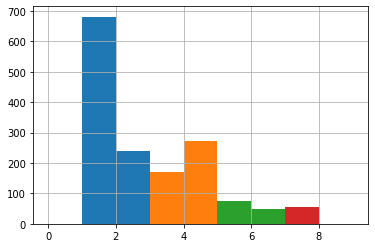

In [28]:
grouped_train_df = train_df.groupby('grouped_ship_count')
grouped_train_df['ships'].hist(bins=np.arange(10))

In [29]:
def sample_ships_for_validation(in_df, total, valid_pct):
    group_cnt = in_df['ImageId'].count()
    frac = int(total * valid_pct * group_cnt // total)
    print("group cnt: {}, fraction: {}".format(group_cnt, frac))
    return in_df.sample(frac, replace=False)

In [30]:
total = train_df['ImageId'].count()
valid_pct = 0.1
valid_df = grouped_train_df.apply(sample_ships_for_validation, total, valid_pct)

group cnt: 921, fraction: 92
group cnt: 443, fraction: 44
group cnt: 123, fraction: 12
group cnt: 56, fraction: 5


In [31]:
all_train_df = train_df[~train_df['ImageId'].isin(valid_df['ImageId'])]

In [32]:
print("training samples: {}, validation sample size: {}".format(all_train_df['ImageId'].count(), valid_df['ImageId'].count()))
training_samples = all_train_df['ImageId'].count()
validation_samples = valid_df['ImageId'].count()

training samples: 1218, validation sample size: 153


In [33]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [34]:
train_gen = make_image_gen(all_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


In [35]:
valid_gen = make_image_gen(valid_df, validation_samples) # pull all validation samples
valid_x, valid_y = next(valid_gen)
print('x', valid_x.shape, valid_x.min(), valid_x.max())
print('y', valid_y.shape, valid_y.min(), valid_y.max())

x (153, 768, 768, 3) 0.0 1.0
y (153, 768, 768, 1) 0 1


In [36]:
# write to CSV and 
masks[masks['ImageId'].isin(all_train_df['ImageId'])].to_csv('{}/train_ship_segmentations_train.csv'.format(ship_dir), index=False)
masks[masks['ImageId'].isin(valid_df['ImageId'])].to_csv('{}/train_ship_segmentations_valid.csv'.format(ship_dir), index=False)      